In [24]:
import astropy.table as apt
import asdf
from astropy.coordinates import SkyCoord

In [2]:
t=apt.Table.read('../../galstreams/galstreams/tracks/track.st.GD-1.pricewhelan2018.ecsv')

In [3]:
t2 = apt.Table.read('../../galstreams/galstreams/tracks/track.st.GD-1.pricewhelan2018.summary.ecsv')

In [4]:
t.write('GD-1.pricewhelan2018.asdf',data_key='track',format='asdf')

In [5]:
t2.write('GD-1.pricewhelan2018.asdf',data_key='summary',format='asdf')

In [11]:
table_tree = {'track':t, 'summary':t2};

In [15]:
a = asdf.AsdfFile(table_tree)
a.write_to('GD-1.pricewhelan2018.asdf')

In [47]:
tt = apt.Table.read('GD-1.pricewhelan2018.asdf',data_key='summary')

In [50]:
tt

StreamName,StreamShortName,InfoFlags,end_o.ra,end_o.dec,end_o.distance,end_o.pm_ra_cosdec,end_o.pm_dec,end_o.radial_velocity,end_f.ra,end_f.dec,end_f.distance,end_f.pm_ra_cosdec,end_f.pm_dec,end_f.radial_velocity,mid.ra,mid.dec,mid.distance,mid.pm_ra_cosdec,mid.pm_dec,mid.radial_velocity,pole.ra,pole.dec,pole.distance
,,,deg,deg,kpc,mas / yr,mas / yr,km / s,deg,deg,kpc,mas / yr,mas / yr,km / s,deg,deg,kpc,mas / yr,mas / yr,km / s,deg,deg,
str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
GD-1,GD-1,1110,124.06463770068025,-7.970772979891113,5.508347580561896,-2.383498192121123,-7.8564837934212495,1.9209032938308283e-10,219.56222712541387,58.20526418569576,10.498741139627292,-8.445978981710363,-1.3661780519199789,2.2529341417616946e-10,200.48591243455303,58.311465160880104,9.999999999926288,-8.409965794914967,-3.975967581427862,1.3176816404824234e-10,34.59870000073543,29.733100003154735,1.0


In [36]:
sc_test = SkyCoord(0*u.deg,0*u.deg)

In [37]:
type(sc) == type(sc_test)

True

In [38]:
SkyCoord(tt['ra'],tt['dec'])

<SkyCoord (ICRS): (ra, dec) in deg
    [(124.0646377 , -7.97077298), (124.06831761, -7.96136413),
     (124.07199789, -7.95195551), ..., (219.52460701, 58.20827053),
     (219.54341787, 58.20676868), (219.56222713, 58.20526419)]>

In [40]:
isinstance(sc, SkyCoord)

True

In [86]:
import galstreams as gst
from matplotlib.path import Path as mpl_path
from astropy.table import Table
import asdf
import astropy.units as u
from astropy.coordinates import SkyCoord
from gala.coordinates import GreatCircleICRSFrame
import numpy as np

In [233]:
class Footprint2D(dict):
    def __init__(self, vertex_coordinates, footprint_type, stream_frame=None):
        if footprint_type=='sky':
            if isinstance(vertex_coordinates, SkyCoord):
                vc = vertex_coordinates
            else:
                vc = SkyCoord(vertex_coordinates)
            self.edges = vc
            self.vertices = np.array([vc.transform_to(stream_frame).phi1, vc.transform_to(stream_frame).phi2]).T

        elif footprint_type=='cartesian':
            self.edges = vertex_coordinates
            self.vertices = vertex_coordinates

        self.stream_frame = stream_frame
        self.footprint = mpl_path(self.vertices)
        
    @classmethod
    def from_vertices(cls, vertex_coordinates, footprint_type):
        return cls(vertices,footprint_type)

    @classmethod
    def from_box(cls, min1, max1, min2, max2, footprint_type):
        vertices = get_vertices_from_box(min1, max1, min2, max2)
        return cls(vertices,footprint_type)

    @classmethod
    def from_file(cls,fname):
        with Table.read(fname) as t:
            vertices = t['vertices']
            footprint_type = t['footprint_type']
        return cls(vertices,footprint_type)

    def get_vertices_from_box(min1, max1, min2, max2):
        return [[min1,min2],[min1,max2],[max1,min2],[max1,max2]]
    
    def inside_footprint(self,data):
        if isinstance(data, SkyCoord):
            if self.stream_frame is None:
                print("can't!")
                return
            else:
                pts = np.array([data.transform_to(self.stream_frame).phi1.value,data.transform_to(self.stream_frame).phi2.value]).T
                return self.footprint.contains_points(pts)
        else:
            return self.footprint.contains_points(data)


In [261]:
class pawprintClass(dict):
    '''Dictionary class to store a "pawprint": 
        polygons in multiple observational spaces that define the initial selection 
        used for stream track modeling, 
        membership calculation / density modeling, and background modeling.
        
        New convention: everything is in phi1 phi2 (don't cross the streams)

        '''

    
    def __init__(self, data):
        
        #we need a way to specify and load the vertices for the footprints. 
        #How do we want to do it? 
        #I sketched here passing the name of the stream 
        #but we could also pass a list of vertices provided by WG2/3

        self.stream_name = data['stream_name']
        self.pawprint_ID = data['pawprint_ID']
        self.stream_frame = data['stream_frame']
        self.width = data['width']
        self.skyprint = {'stream':Footprint2D(data['stream_vertices'],footprint_type='sky',stream_frame=self.stream_frame), 
                        'background':Footprint2D(data['background_vertices'],footprint_type='sky',stream_frame=self.stream_frame)} 
        #WG3: how to implement distance dependence in isochrone selections?
        self.cmd_filters = data['cmd_filters']
        self.cmdprint = {}
        if self.cmd_filters is not None:
            for k in data.cmd_filters.keys():
                self.cmdprint[k] = Footprint2D(data['cmd_vertices'][k], footprint_type='cartesian')
        if data['pm_vertices'] is not None:
            self.pmprint = Footprint2D(data['pm_vertices'],footprint_type='sky') #polygon(s) in proper-motion space mu_phi1, mu_phi2
        else:
            self.pmprint = {}
        self.track = data['track']

    @classmethod
    def load_pawprint(cls,fname):
        #TODO: load all the stuff from the file into a dictionary called data and call the main init function
        ...
        return cls(data)
        

    
    @classmethod
    def pawprint_from_galstreams(cls,stream_name,pawprint_ID):
        
        
        galstreams_tracks = '../../galstreams/galstreams/tracks/'
    
        def _make_track_file_name(stream_name,pawprint_ID):
            return galstreams_tracks+'track.st.'+stream_name+'.'+pawprint_ID+".ecsv"
    
        def _make_summary_file_name(stream_name,pawprint_ID):
            return galstreams_tracks+'track.st.'+stream_name+'.'+pawprint_ID+".summary.ecsv"
        
        def _get_stream_frame_from_file(summary_file):
            t = apt.QTable.read(summary_file)
        
            x = dict()
            atts = [x.replace('mid.','') for x in t.keys() if 'mid' in x ]
            for att in atts:  #we're effectively looping over skycoords defined for mid here (ra, dec, ...)
                x[att] = t[f'mid.{att}'][0]   #<- make sure to set it up as a scalar. if not, frame conversions get into trouble
            mid_point = SkyCoord(**x) 

            x = dict()
            atts = [x.replace('pole.','') for x in t.keys() if 'pole' in x ]
            for att in atts:  #we're effectively looping over skycoords defined for pole here (ra, dec, ...)
                x[att] = t[f'pole.{att}'][0]
            #Make sure to set the pole's distance attribute to 1 (zero causes problems, when transforming to stream frame coords)
            x["distance"] = 1.*u.kpc   #it shouldn't matter, but if it's zero it does crazy things
            mid_pole = SkyCoord(**x)

            return GreatCircleICRSFrame(pole=mid_pole, ra0=mid_point.icrs.ra)

        data = {}
        data['stream_name'] = stream_name
        data['pawprint_ID'] = pawprint_ID

        track_file = _make_track_file_name(stream_name,pawprint_ID) 
        summary_file = _make_summary_file_name(stream_name,pawprint_ID) 
        data['stream_frame'] = _get_stream_frame_from_file(summary_file)

        data['track'] = gst.Track6D(stream_name=data['stream_name'], track_name=data['pawprint_ID'], track_file=track_file, summary_file=summary_file)
        data['width'] = 1.0*u.deg
        data['stream_vertices'] = data['track'].create_sky_polygon_footprint_from_track(width=data['width'], phi2_offset=0.*u.deg)
        data['background_vertices'] = data['track'].create_sky_polygon_footprint_from_track(width=data['width'], phi2_offset=3.*u.deg)
        data['cmd_filters'] = None
        data['cmd_vertices'] = None
        data['pm_vertices'] = None


        return cls(data)




    def save_pawprint(self):
        fname = self.stream_name+self.pawprint_ID+'.asdf'
        tree = {
            'stream_name':self.stream_name,
            'pawprint_ID':self.pawprint_ID,
            'stream_frame':self.stream_frame,
            'cmd_filters': self.cmd_filters,
            'width':self.width,
            'on_stream':{
                        'sky':self.skyprint['stream'],
                        'cmd':self.cmdprint,
                        'pm':self.pmprint,
                        },
            'off_stream':self.skyprint['background'],
            'track':self.track
        }
        out = asdf.AsdfFile(tree)
        out.write_to(fname)
    


In [291]:
from pawprint import *

In [268]:
#load a pawprint from galstreams (sky only)
p = pawprintClass.pawprint_from_galstreams('Jhelum-a','bonaca2019')

In [269]:
#Generate random points on the sphere in an area around the track
rao,raf = np.min(p.track.track.ra.deg), np.max(p.track.track.ra.deg)
deco,decf = np.min(p.track.track.dec.deg),np.max(p.track.track.dec.deg)
field_ra, field_dec = gst.get_random_spherical_angles(5000,az=[rao,raf],
                                                           lat=[deco,decf],degree=True)
field = SkyCoord(ra=field_ra*u.deg, dec=field_dec*u.deg, frame='icrs')

#generate masks for the on- and off-stream sky footprints
on = p.skyprint['stream'].inside_footprint(field)
off = p.skyprint['background'].inside_footprint(field)

In [264]:
from matplotlib import pyplot as plt

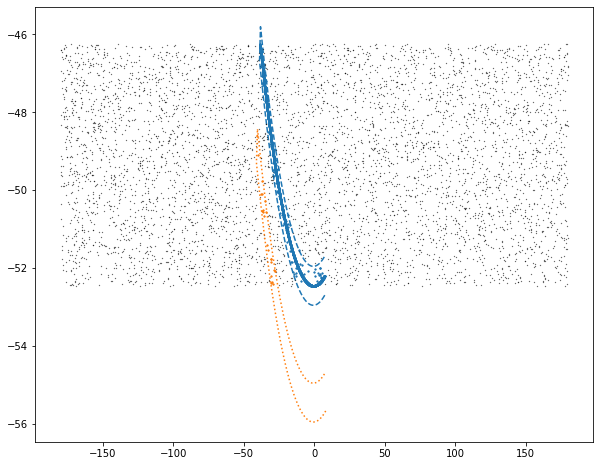

In [271]:

plt.figure(1,figsize=(10,8))
ax = plt.subplot(111)

#plot the track
ax.plot(p.track.track.ra.wrap_at(180*u.deg), p.track.track.dec, '.', ms=2., color='C0')

#plot the on-stream polygon
ax.plot(p.skyprint['stream'].edges.icrs.ra.wrap_at(180*u.deg), p.skyprint['stream'].edges.icrs.dec, ls='--', color='C0')

#plot random background "field" points 
ax.plot(field.ra.wrap_at(180*u.deg), field.dec, 'k.', ms=0.5)

#plot the field points inside the polygon footprint
ax.plot(field.ra[on].wrap_at(180*u.deg), field.dec[on], '.', ms=2.5, color='C0')

#Plot the off-stream polygon footprint and points selected inside it
ax.plot(p.skyprint['background'].edges.icrs.ra.wrap_at(180*u.deg), p.skyprint['background'].edges.icrs.dec, ls=':', color='C1')
ax.plot(field.ra[off].wrap_at(180*u.deg), field.dec[off], '.', ms=2.5, color='C1')

(-10.0, 10.0)

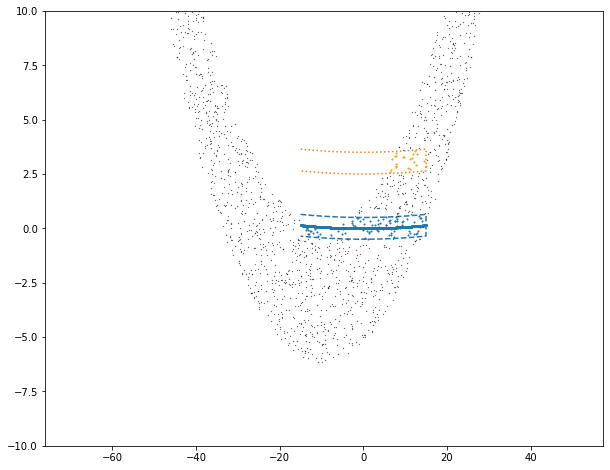

In [290]:

plt.figure(1,figsize=(10,8))
ax = plt.subplot(111)

#Plot the track in phi1/phi2
ax.plot(p.track.track.transform_to(p.stream_frame).phi1, 
        p.track.track.transform_to(p.stream_frame).phi2, '.', ms=2., color='C0')
#plot the on-stream polygon 
ax.plot(p.skyprint['stream'].edges.transform_to(p.stream_frame).phi1, 
        p.skyprint['stream'].edges.transform_to(p.stream_frame).phi2, ls='--', color='C0')
#plot the off-stream polygon
ax.plot(p.skyprint['background'].edges.transform_to(p.stream_frame).phi1, 
        p.skyprint['background'].edges.transform_to(p.stream_frame).phi2, ls=':', color='C1')

ax.plot(field.transform_to(p.stream_frame).phi1, field.transform_to(p.stream_frame).phi2,'.k', ms=0.5)
ax.plot(field[on].transform_to(p.stream_frame).phi1, field[on].transform_to(p.stream_frame).phi2,'.', ms=2)
ax.plot(field[off].transform_to(p.stream_frame).phi1, field[off].transform_to(p.stream_frame).phi2,'.', color='orange', ms=2)

ax.set_ylim(-10,10)

In [292]:
a = asdf.open('Jhelum-abonaca2019.asdf')

/opt/anaconda3/envs/cats/lib/python3.8/site-packages/asdf/schema.py:301: AsdfWarning: Unable to locate schema file for 'tag:astropy.org:astropy/coordinates/frames/greatcircleicrsframe-1.0.0': 'http://astropy.org/schemas/astropy/coordinates/frames/greatcircleicrsframe-1.0.0'
  warnings.warn(msg.format(tag, schema_uri), AsdfWarning)
/opt/anaconda3/envs/cats/lib/python3.8/site-packages/asdf/yamlutil.py:300: AsdfConversionWarning: tag:astropy.org:astropy/coordinates/frames/greatcircleicrsframe-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(


In [295]:
a['stream_name']

'Jhelum-a'